# Basic burn probability benchmarking
This script compares OCR burn probability data to historical U.S. fire perimeter data as a general, surface-level benchmark of the burn probabilities. The benchmark test is adapted from [Moran et al. 2025](https://www.nature.com/articles/s41598-025-07968-6) (scientific reports), which applied similar methods to annually benchmark FSim-derived burn probability data from 2020-2023 in the state of California. 

We focus on the 2011 burn probability map (rather than the future 2047 case) and compare it to the full historical burn perimeter dataset. This approach implicitly assumes that the 2011 map does a reasonable job capturing historical burn probabilities. We're okay with this assumption because the only thing that makes the 2011 map relevant for the year 2011 is the land surface boundary conditions (not the specific weather of that year), which have been relatively stable across the historical record at the CONUS-scale. 

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# --- set up processed data cases
datpath = 's3://carbonplan-ocr/evaluation/1.1.0/benchmarking-processed/'
slc = {
    'CONUS': {
        'df1a_expandFactor_all': 8e6,
        'df1a_expandFactor_NB': 6e6,
        'df1b_vmax_all': 0.001,
        'df1b_vmax_NB': 0.001,
    },
    # 'West of -98': {
    #     'df1a_expandFactor_all': 8e6,
    #     'df1a_expandFactor_NB': 6e6,
    #     'df1b_vmax_all': 0.001,
    #     'df1b_vmax_NB': 0.001,
    # },
    # 'East of -98': {
    #     'df1a_expandFactor_all': 8e6,
    #     'df1a_expandFactor_NB': 8e6,
    #     'df1b_vmax_all': 0.001,
    #     'df1b_vmax_NB': 0.001,
    # },
}

# ---------------------------------------------------------
# select the slice to plot
slicename = 'CONUS'
# ---------------------------------------------------------

# Bechmark test: BP of burned and non-burned pixels
Reads in and plots frequency data for burn probability across N bins, repeated for all data and for just the "non-burnable" pixels of Riley et al.

In [4]:
# --- read in and process data
df1a = pd.read_parquet(os.path.join(datpath, f'{slicename}_area-wt_maskdf.parquet'))

# ( set bp range )
bp_range = (
    0,
    0.14,
)  # max confirmed in `benchmarking_process_inputs.ipynb` with: bp.max(skipna=True).compute()


# compute median, mean, and cdf
def weighted_stats(bin_centers, weights):
    mean = np.sum(bin_centers * weights) / np.sum(weights)
    cdf = np.cumsum(weights) / np.sum(weights)
    median = np.interp(0.5, cdf, bin_centers)
    return mean, median, cdf


# [ ALL DATA ]
burned_mean, burned_median, burned_cdf = weighted_stats(
    df1a['bin_centers'], df1a['burned_BPdensity']
)
unburned_mean, unburned_median, unburned_cdf = weighted_stats(
    df1a['bin_centers'], df1a['unburned_BPdensity']
)
# [ UNBURNABLE ONLY ]
burned_mean_unburnable, burned_median_unburnable, burned_cdf_unburnable = weighted_stats(
    df1a['bin_centers'], df1a['burned_BPdensity_NB']
)
unburned_mean_unburnable, unburned_median_unburnable, unburned_cdf_unburnable = weighted_stats(
    df1a['bin_centers'], df1a['unburned_BPdensity_NB']
)

# replace zero density with nan (to avoid plotting zero density)
df1a['burned_BPdensity'] = df1a['burned_BPdensity'].replace(0, np.nan)
df1a['unburned_BPdensity'] = df1a['unburned_BPdensity'].replace(0, np.nan)
df1a['burned_BPdensity_NB'] = df1a['burned_BPdensity_NB'].replace(0, np.nan)
df1a['unburned_BPdensity_NB'] = df1a['unburned_BPdensity_NB'].replace(0, np.nan)

### Plot all data

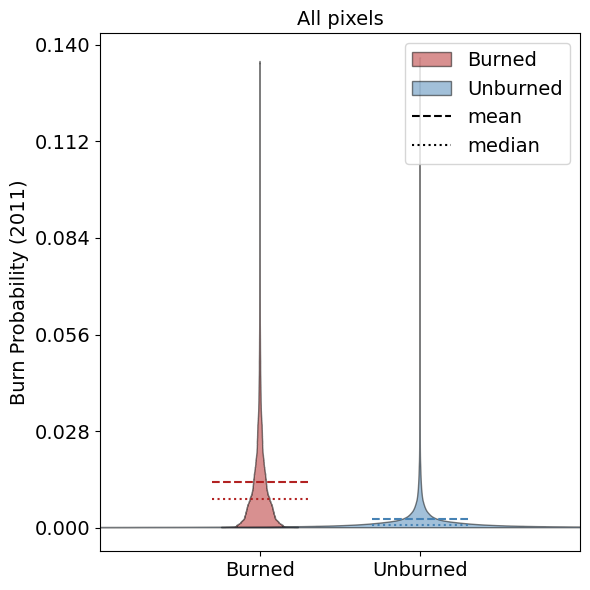

In [5]:
# [ ALL DATA ]
# --- aesthetics -------------
burncol = 'firebrick'
unburncol = 'steelblue'
edgecol = 'black'
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = '--'
ls_median = ':'
line_buff = 0.3
# ----------------------------

# plot
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0]) * slc[slicename].get(
    'df1a_expandFactor_all', 3e6
)

# violin shapes
ax.fill_betweenx(
    df1a['bin_centers'],
    -df1a['burned_BPdensity'] * width,
    df1a['burned_BPdensity'] * width,
    edgecolor=edgecol,
    facecolor=burncol,
    alpha=fill_alph,
    label='Burned',
)
ax.fill_betweenx(
    df1a['bin_centers'],
    1 - df1a['unburned_BPdensity'] * width,
    1 + df1a['unburned_BPdensity'] * width,
    edgecolor=edgecol,
    facecolor=unburncol,
    alpha=fill_alph,
    label='Unburned',
)

# mean and median lines
ax.plot(
    [-line_buff, line_buff],
    [burned_mean, burned_mean],
    color=burncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff, line_buff],
    [burned_median, burned_median],
    color=burncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_mean, unburned_mean],
    color=unburncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_median, unburned_median],
    color=unburncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
# (lines for label only)
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label='mean')
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label='median')

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel('Burn Probability (2011)', fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Burned', 'Unburned'])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc='upper right')
plt.title('All pixels', fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()

### Plot non-burnable data only

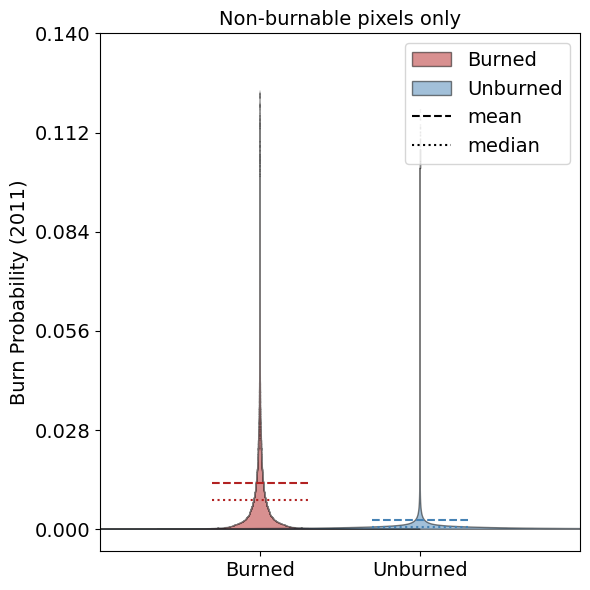

In [6]:
# [ NON-BURNABLE ONLY ]
# --- aesthetics -------------
burncol = 'firebrick'
unburncol = 'steelblue'
edgecol = 'black'
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = '--'
ls_median = ':'
line_buff = 0.3
# ----------------------------

# plot
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0]) * slc[slicename].get(
    'df1a_expandFactor_NB', 3e6
)

# violin shapes
ax.fill_betweenx(
    df1a['bin_centers'],
    -df1a['burned_BPdensity_NB'] * width,
    df1a['burned_BPdensity_NB'] * width,
    edgecolor=edgecol,
    facecolor=burncol,
    alpha=fill_alph,
    label='Burned',
)
ax.fill_betweenx(
    df1a['bin_centers'],
    1 - df1a['unburned_BPdensity_NB'] * width,
    1 + df1a['unburned_BPdensity_NB'] * width,
    edgecolor=edgecol,
    facecolor=unburncol,
    alpha=fill_alph,
    label='Unburned',
)

# mean and median lines
ax.plot(
    [-line_buff, line_buff],
    [burned_mean, burned_mean],
    color=burncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff, line_buff],
    [burned_median, burned_median],
    color=burncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_mean, unburned_mean],
    color=unburncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_median, unburned_median],
    color=unburncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
# (lines for label only)
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label='mean')
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label='median')

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel('Burn Probability (2011)', fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Burned', 'Unburned'])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc='upper right')
plt.title('Non-burnable pixels only', fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()

### Plot as CDFs

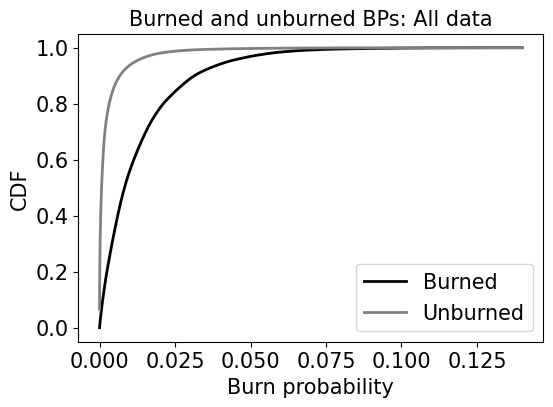

In [7]:
# [ ALL DATA ]
# ( use plotdata from above )
# --- PLOT
# [ aesthetics ]
lsize = 2
burncol = 'black'
unburncol = 'gray'
pgrid = False
fsize = 15
# -----------------

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    df1a['bin_centers'], burned_cdf, label='Burned', linestyle='-', linewidth=lsize, color=burncol
)
plt.plot(
    df1a['bin_centers'],
    unburned_cdf,
    label='Unburned',
    linestyle='-',
    linewidth=lsize,
    color=unburncol,
)
plt.xlabel('Burn probability', fontsize=fsize)
plt.ylabel('CDF', fontsize=fsize)
plt.title('Burned and unburned BPs: All data', fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.grid(pgrid)
plt.legend(loc='lower right', fontsize=fsize)

plt.show()
plt.close()

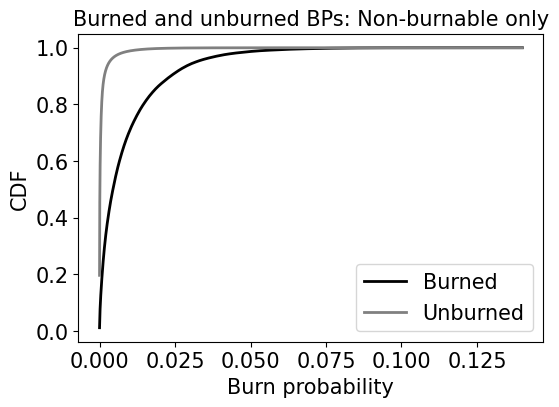

In [8]:
# [ NON-BURNABLE DATA ONLY ]
# ( use plotdata from above )
# --- PLOT
# [ aesthetics ]
lsize = 2
burncol = 'black'
unburncol = 'gray'
pgrid = False
fsize = 15
# -----------------

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    df1a['bin_centers'],
    burned_cdf_unburnable,
    label='Burned',
    linestyle='-',
    linewidth=lsize,
    color=burncol,
)
plt.plot(
    df1a['bin_centers'],
    unburned_cdf_unburnable,
    label='Unburned',
    linestyle='-',
    linewidth=lsize,
    color=unburncol,
)
plt.xlabel('Burn probability', fontsize=fsize)
plt.ylabel('CDF', fontsize=fsize)
plt.title('Burned and unburned BPs: Non-burnable only', fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.grid(pgrid)
plt.legend(loc='lower right', fontsize=fsize)

plt.show()
plt.close()

In [ ]:
# ------